In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Define VGG16 architecture
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(4096, 100),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16().to(device)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276)),
])

train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=300)

# Evaluation function
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
def train(num_epochs=200):
    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        scheduler.step()
        train_accuracy = 100 * correct / total
        test_accuracy = evaluate(test_loader)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")
    final_test_accuracy = evaluate(test_loader)
    print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

# Run training and evaluation
train()


100%|██████████| 169M/169M [00:03<00:00, 49.0MB/s]


Epoch 1, Loss: 4.5937, Train Acc: 1.30%, Test Acc: 1.70%
Epoch 2, Loss: 4.4947, Train Acc: 1.90%, Test Acc: 2.18%
Epoch 3, Loss: 4.3549, Train Acc: 2.84%, Test Acc: 3.38%
Epoch 4, Loss: 4.2199, Train Acc: 3.98%, Test Acc: 4.63%
Epoch 5, Loss: 4.1173, Train Acc: 5.17%, Test Acc: 5.56%
Epoch 6, Loss: 4.0066, Train Acc: 6.49%, Test Acc: 6.95%
Epoch 7, Loss: 3.9095, Train Acc: 7.51%, Test Acc: 8.44%
Epoch 8, Loss: 3.8111, Train Acc: 8.92%, Test Acc: 10.50%
Epoch 9, Loss: 3.7188, Train Acc: 10.40%, Test Acc: 12.57%
Epoch 10, Loss: 3.6170, Train Acc: 12.01%, Test Acc: 11.66%
Epoch 11, Loss: 3.5236, Train Acc: 14.02%, Test Acc: 14.39%
Epoch 12, Loss: 3.4374, Train Acc: 15.03%, Test Acc: 16.64%
Epoch 13, Loss: 3.3725, Train Acc: 16.32%, Test Acc: 17.45%
Epoch 14, Loss: 3.3154, Train Acc: 17.44%, Test Acc: 18.17%
Epoch 15, Loss: 3.2481, Train Acc: 18.76%, Test Acc: 19.49%
Epoch 16, Loss: 3.1949, Train Acc: 19.59%, Test Acc: 20.88%
Epoch 17, Loss: 3.1378, Train Acc: 20.79%, Test Acc: 21.91%
Epoc

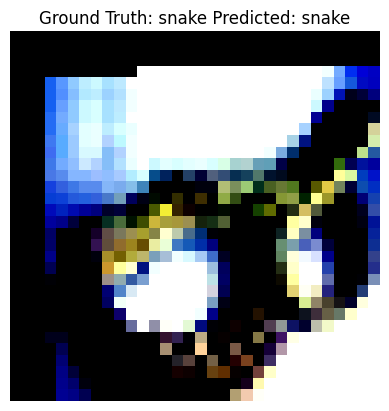

In [ ]:
# Interactive function for user input and image display
def predict_image(index):
    model.eval()
    image, label = test_dataset[index]
    image_tensor = image.unsqueeze(0).to(device)
    output = model(image_tensor)
    _, predicted_class = output.max(1)

    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title(f'Ground Truth: {test_dataset.classes[label]} Predicted: {test_dataset.classes[predicted_class.item()]}')
    plt.axis("off")
    plt.show()

# Example usage
predict_image(81)

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "vgg16_cifar100.pth")
print("Model saved as vgg16_cifar100.pth")


Model saved as vgg16_cifar100.pth


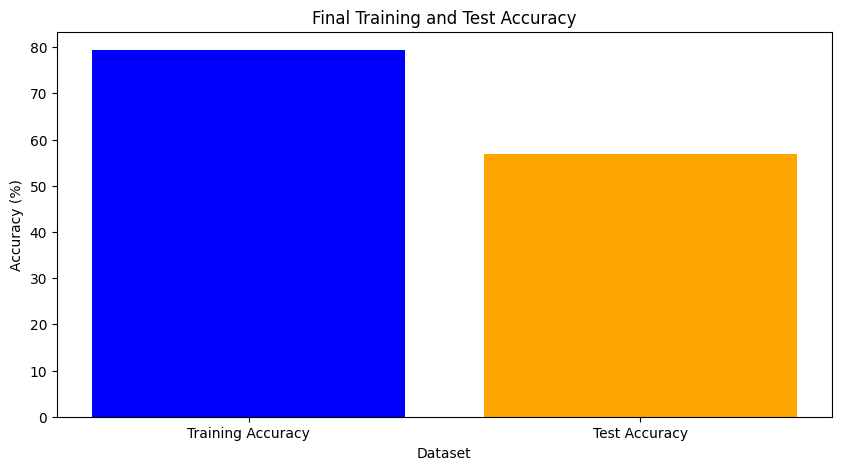

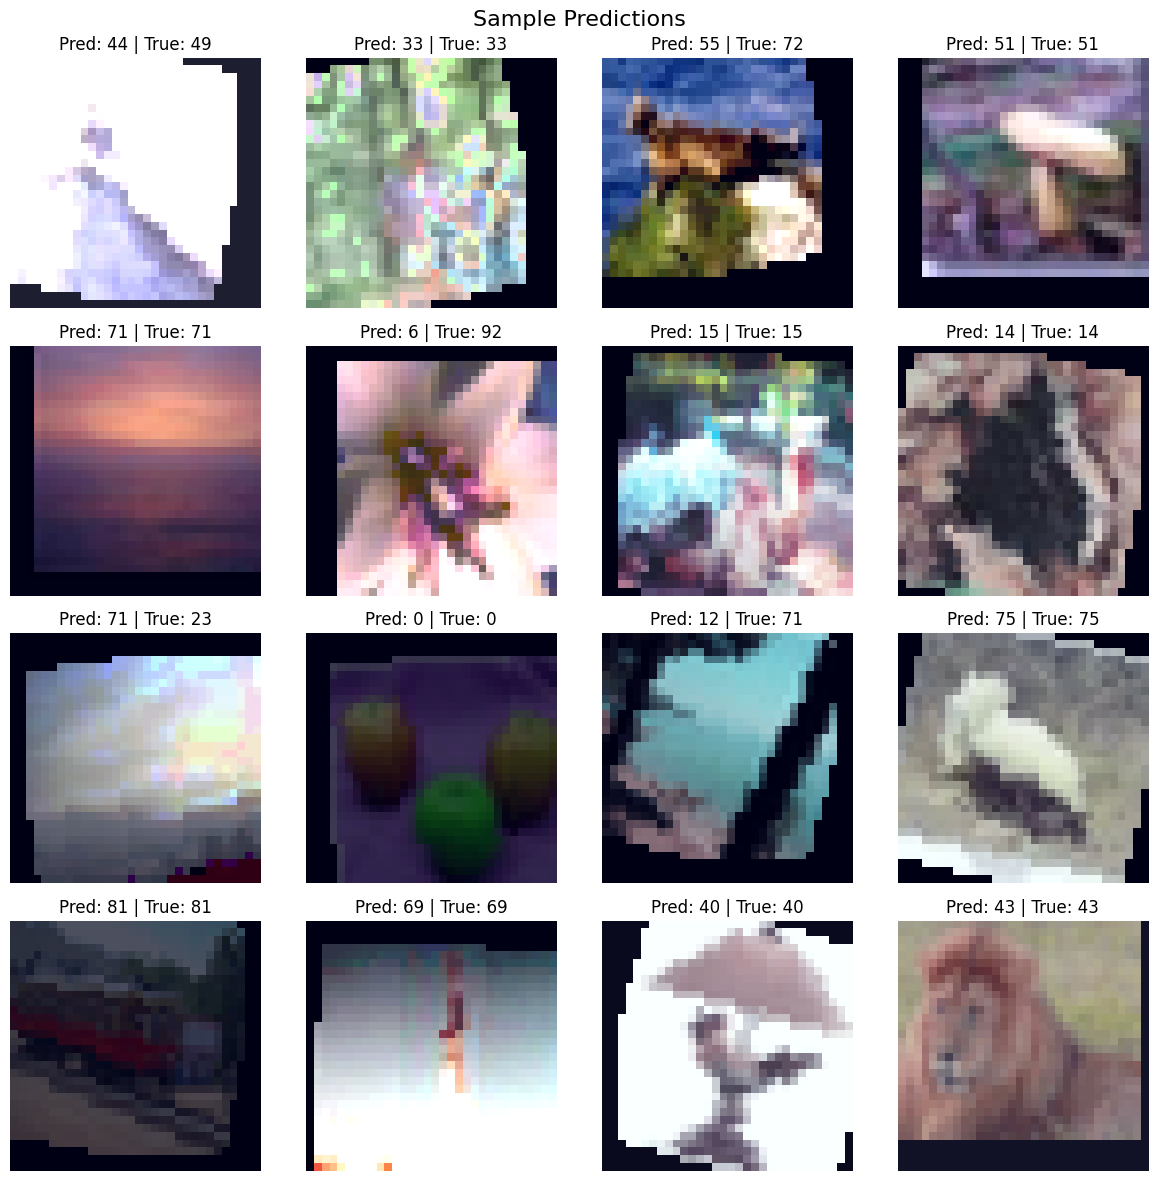

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy curves using the evaluate function
def plot_accuracy():
    train_accuracy = evaluate(train_loader)
    test_accuracy = evaluate(test_loader)

    plt.figure(figsize=(10, 5))
    plt.bar(['Training Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Training and Test Accuracy')
    plt.savefig("accuracy_curves.png")
    plt.show()

# Sample Images with Predictions
def plot_predictions(loader, num_images=16):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle("Sample Predictions", fontsize=16)

    for i, ax in enumerate(axes.flat):
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        image = np.clip(image * 0.267 + 0.507, 0, 1)  # Unnormalize
        ax.imshow(image)
        ax.set_title(f"Pred: {predicted[i].item()} | True: {labels[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("sample_predictions.png")
    plt.show()

# Generate the plots
plot_accuracy()
plot_predictions(test_loader)
